In [34]:
import numpy as np
import pandas as pd

In [35]:
df=pd.read_csv('new_data/first.csv')
df.head()

,Name,m/z,Discarded,UUID
0,Pyruvic acid,87.0082,True,f97ffd62-45f5-4fb3-977a-e198e55721ed
1,L-Alanine,88.0403,True,26afe4a7-cdd2-4e49-9b1e-0f54f57a978a
2,Lactic acid,89.0239,True,022f1cdf-2229-4394-a928-4d6369cff8f3
3,Phosphate,96.9691,False,53e2bc8b-46af-4ce3-8734-0f36e0b43178
4,Serine,104.0352,True,98b176c2-e919-4274-aa3c-32ce0772ca52


In [36]:
df.isnull().sum()

Name         0
m/z          0
Discarded    0
UUID         0
dtype: int64

In [37]:
npz_dir = 'new_data/first'

In [38]:
import numpy as np

# Path to your .npz file
npz_path = "new_data/first/f97ffd62-45f5-4fb3-977a-e198e55721ed.npz"  # Replace with actual path

# Load the file
with np.load(npz_path) as data:
    print("Keys in the .npz file:", data.files)

    # Print shape and basic info for each key
    for key in data.files:
        print(f"\nKey: {key}")
        print("Shape:", data[key].shape)
        print("First 5 values:", data[key][:5])  # You can print more if needed


Keys in the .npz file: ['mz', 'intensity']

Key: mz
Shape: (80,)
First 5 values: [86.99064875 86.9910837  86.99151866 86.99195361 86.99238857]

Key: intensity
Shape: (80,)
First 5 values: [4.8089743 8.8732    5.7162895 7.9441743 5.0840626]


In [39]:
# loading npz 
import os
spec_id=df.loc[0,'UUID']
npz_path=os.path.join(npz_dir,f"{spec_id}.npz")

with np.load(npz_path) as npz:
    mz = npz['mz']
    intensity = npz['intensity']

print("\nFirst Spec ID:", spec_id)
print("m/z shape:", mz.shape)
print("Intensity shape:", intensity.shape)
print("\nSample m/z values:", mz[:10])
print("Sample intensities:", intensity[:10])


First Spec ID: f97ffd62-45f5-4fb3-977a-e198e55721ed
m/z shape: (80,)
Intensity shape: (80,)

Sample m/z values: [86.99064875 86.9910837  86.99151866 86.99195361 86.99238857 86.99282354
 86.9932585  86.99369347 86.99412844 86.99456341]
Sample intensities: [4.8089743 8.8732    5.7162895 7.9441743 5.0840626 6.9757705 5.213771
 9.002102  4.0344863 9.366201 ]


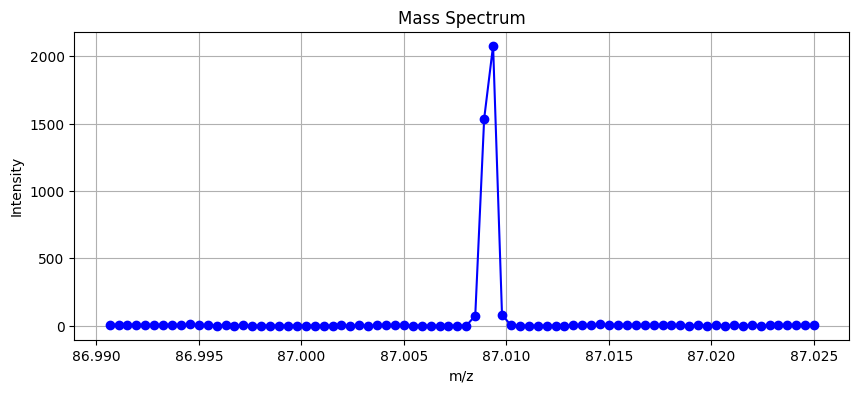

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(mz, intensity, marker='o', linestyle='-', color='blue')
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title("Mass Spectrum")
plt.grid(True)
plt.show()

### Training with intensity and m/z Spectra

In [41]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [42]:
# Create feature vectors: [normalized mz values + normalized intensities]
X = []
y = []

for _, row in df.iterrows():
    uuid = row['UUID']
    label = 1 if row['Discarded'] else 0

    npz_path = os.path.join(npz_dir, f"{uuid}.npz")
    if not os.path.exists(npz_path):
        continue

    with np.load(npz_path) as data:
        mz = data['mz']
        intensity = data['intensity']

    # Normalize intensity and mz
    norm_intensity = intensity / (np.max(intensity) + 1e-8)
    norm_mz = (mz - np.min(mz)) / (np.max(mz) - np.min(mz) + 1e-8)

    # Combine both into a single vector (length 160)
    combined_vector = np.concatenate([norm_mz, norm_intensity])
    X.append(combined_vector.tolist())
    y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# Train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.53      0.56      0.54        18
    Discarded (1)       0.82      0.80      0.81        46

         accuracy                           0.73        64
        macro avg       0.67      0.68      0.68        64
     weighted avg       0.74      0.73      0.74        64



### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

Lr = LogisticRegression(max_iter=1000, random_state=42)
Lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [46]:
# Evaluate
y_pred = Lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.52      0.72      0.60        18
    Discarded (1)       0.87      0.74      0.80        46

         accuracy                           0.73        64
        macro avg       0.70      0.73      0.70        64
     weighted avg       0.77      0.73      0.75        64



In [47]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [48]:
# Predict and evaluate
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.55      0.61      0.58        18
    Discarded (1)       0.84      0.80      0.82        46

         accuracy                           0.75        64
        macro avg       0.70      0.71      0.70        64
     weighted avg       0.76      0.75      0.75        64



### SVM

In [49]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [50]:
# Predict and evaluate
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.52      0.67      0.59        18
    Discarded (1)       0.85      0.76      0.80        46

         accuracy                           0.73        64
        macro avg       0.69      0.71      0.69        64
     weighted avg       0.76      0.73      0.74        64



In [51]:
print(norm_intensity)

[0.29649565 0.2815562  0.31923398 0.30625167 0.31123933 0.31795794
 0.29588914 0.32190034 0.30129012 0.33022904 0.30848876 0.33914238
 0.3240481  0.36654997 0.34216323 0.364082   0.33864298 0.34881833
 0.35824293 0.36810017 0.41741315 0.42088568 0.44545048 0.38333616
 0.36937526 0.31071496 0.31184265 0.29402587 0.37835053 0.4370315
 0.52807933 0.4898667  0.40869588 0.37879983 0.32272297 0.29696995
 0.28039822 0.34592092 0.545332   1.         0.99573237 0.56054157
 0.2952728  0.19429573 0.20571822 0.2045616  0.25794083 0.23810294
 0.26711258 0.22639847 0.23723306 0.20356174 0.22959471 0.19910012
 0.21519794 0.1665269  0.1726433  0.14052434 0.14870967 0.14981571
 0.10574956 0.13424535 0.09644484 0.12876904 0.09344941 0.12583435
 0.09183588 0.12471715 0.09038415 0.12213918 0.090745   0.11640304
 0.10164966 0.10029984 0.11631711 0.08363512 0.11479437 0.08076503
 0.11415634 0.07926912]


### Adding features as m/z, mz, intensity in spectrum

In [52]:
# Prepare feature and label arrays
X_combined = []

for _, row in df.iterrows():
    mz_value = row['m/z']

    # Combine features
    combined_features = [mz_value] + norm_mz.tolist() + norm_intensity.tolist()
    X_combined.append(combined_features)

# Convert to arrays
X = np.array(X_combined)


# Split and train Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
print(X.shape)
print(y.shape)

(316, 161)
(316,)


### Random Forest

In [54]:
# Train the classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.40      0.33      0.36        18
    Discarded (1)       0.76      0.80      0.78        46

         accuracy                           0.67        64
        macro avg       0.58      0.57      0.57        64
     weighted avg       0.66      0.67      0.66        64



### Logistic Regression

In [56]:
Lr = LogisticRegression(max_iter=1000, random_state=42)
Lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [57]:
# Evaluate
y_pred = Lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.00      0.00      0.00        18
    Discarded (1)       0.72      1.00      0.84        46

         accuracy                           0.72        64
        macro avg       0.36      0.50      0.42        64
     weighted avg       0.52      0.72      0.60        64



c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

### Naive Bayes


In [58]:
nb = GaussianNB()
nb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [59]:
# Evaluate
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.00      0.00      0.00        18
    Discarded (1)       0.72      1.00      0.84        46

         accuracy                           0.72        64
        macro avg       0.36      0.50      0.42        64
     weighted avg       0.52      0.72      0.60        64



c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [61]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_xgb.fit(X_train, y_train)

c:\Users\Nikitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:59:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [62]:
y_pred = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Not Discarded (0)", "Discarded (1)"]))

                   precision    recall  f1-score   support

Not Discarded (0)       0.35      0.33      0.34        18
    Discarded (1)       0.74      0.76      0.75        46

         accuracy                           0.64        64
        macro avg       0.55      0.55      0.55        64
     weighted avg       0.63      0.64      0.64        64

